# Monthly % Gain Clustering (Same-Month Similarity)

This notebook builds a feature dataset where each asset is represented by its **monthly percentage gains over time**, and clusters assets whose % gain in the *same month* is similar.

Algorithms (on PCA embedding of monthly return vectors):
- KMeans
- DBSCAN
- Gaussian Mixture Model (GMM)

Outputs:
- cluster memberships for each algorithm
- monthly % gain (cluster average) plotted vs time
- common daily price charts for each cluster

Time split:
- clustering fit uses the train window (first 7 years)
- charts use full available history


In [1]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [2]:
# Resolve project root robustly
CWD = Path.cwd().resolve()
PROJECT_ROOT = None
for p in [CWD, *CWD.parents]:
    if (p / 'dataset').exists() and (p / 'src').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError(f'Could not locate project root from CWD={CWD}')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)


PROJECT_ROOT: /home/anivarth/college/quant-task


In [3]:
from src.backtester.data import load_cleaned_assets, align_close_prices

assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index()

TRAIN_YEARS = 7
TEST_MONTHS = 18
start = pd.Timestamp(close_daily.index.min())
end = pd.Timestamp(close_daily.index.max())
train_end = start + pd.DateOffset(years=TRAIN_YEARS)
test_start = end - pd.DateOffset(months=TEST_MONTHS)

if train_end >= test_start:
    raise ValueError('Not enough history for requested time split')

print('date range:', start.date(), '->', end.date())
print('train_end:', train_end.date(), 'test_start:', test_start.date())


date range: 2016-01-25 -> 2026-01-16
train_end: 2023-01-25 test_start: 2024-07-16


monthly_ret_train shape: (83, 100)


Asset_001  Asset_002  Asset_003  Asset_004  Asset_005  Asset_006  \
Date                                                                           
2016-02-29  -0.001288  -0.069789  -0.060812  -0.058739   0.074573  -0.047144   
2016-03-31   0.127211   0.085495   0.067616   0.074423   0.136161   0.067153   
2016-04-30  -0.139921  -0.097049  -0.069723   0.111094  -0.002807   0.030500   
2016-05-31   0.071773   0.070197   0.061630   0.095817   0.318360   0.010461   
2016-06-30  -0.042660  -0.034528  -0.059289  -0.009920   0.006207  -0.038128   

            Asset_007  Asset_008  Asset_009  Asset_010  ...  Asset_091  \
Date                                                    ...              
2016-02-29   0.003818   0.033906  -0.083421  -0.026274  ...  -0.000349   
2016-03-31   0.197155   0.057464   0.000139   0.056500  ...   0.028305   
2016-04-30   0.047830   0.025373   0.048882   0.009937  ...   0.089356   
2016-05-31  -0.072811  -0.033957   0.000014   0.023819  ...  -0.044149   
2016-06-30  -0.049053   0.030241   0.049580  -0.060426  ...   0.036435   

            Asset_092  Asset_093  Asset_094  Asset_095  Asset_096  Asset_097  \
Date                                                                           
2016-02-29   0.014308   0.017696  -0.088426  -0.075965   0.046409  -0.036265   
2016-03-31   0.034228   0.057194   0.121100   0.032345   0.092824  -0.015052   
2016-04-30   0.062179  -0.043102   0.140803   0.025587   0.020305   0.026743   
2016-05-31   0.032184   0.065064  -0.015251   0.088595   0.014447   0.183256   
2016-06-30   0.022836   0.001250   0.025320   0.011927  -0.012131   0.081761   

            Asset_098  Asset_099  Asset_100  
Date                                         
2016-02-29  -0.027988  -0.022153   0.056418  
2016-03-31   0.076326   0.095160   0.066694  
2016-04-30   0.009315  -0.001089   0.059029  
2016-05-31  -0.007191   0.101394  -0.024001  
2016-06-30   0.039625   0.071077  -0.013243  

[5 rows x 100 columns]

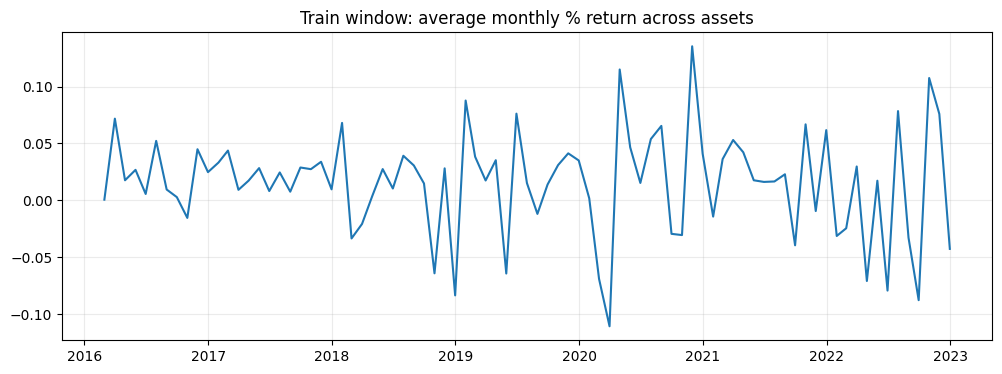

In [4]:
# Feature dataset: monthly percentage gain per asset.
# We use month-end closes and compute month-over-month returns.

# Ensure continuity before resampling
close_ff = close_daily.ffill().bfill()

close_monthly = close_ff.resample('ME').last()  # pandas: 'M' deprecated -> use 'ME'
monthly_ret = close_monthly.pct_change().dropna(how='all')

# Train window for fitting clustering
monthly_ret_train = monthly_ret.loc[monthly_ret.index < train_end].copy()

print('monthly_ret_train shape:', monthly_ret_train.shape)
display(monthly_ret_train.head())

# Plot the monthly % gain feature dataset (average across assets) vs time
avg_ret = monthly_ret_train.mean(axis=1)
plt.figure(figsize=(12,4))
plt.plot(avg_ret.index, avg_ret.values)
plt.title('Train window: average monthly % return across assets')
plt.grid(True, alpha=0.25)
plt.show()


In [5]:
# Build asset vectors: each asset -> vector of monthly returns over time.
# Similarity is enforced month-by-month (same timestamps across assets).

X_assets = monthly_ret_train.T  # [assets, months]
assets = X_assets.index.to_list()

# Impute missing monthly returns as 0 (no change) after standardization baseline.
# (Alternative: drop assets with many missing values.)
imp = SimpleImputer(strategy='constant', fill_value=0.0)
X = imp.fit_transform(X_assets.to_numpy(dtype=float))

# Standardize features (months) so distance focuses on shape
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

# PCA embedding
N_PCA = 10
pca = PCA(n_components=min(N_PCA, Xz.shape[1]), random_state=42)
Z = pca.fit_transform(Xz)
print('Z shape:', Z.shape)

# 1) KMeans
N_CLUSTERS = 8
km = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
km_labels = km.fit_predict(Z)

# 2) DBSCAN
# eps is scale-dependent; tuned for standardized PCA space.
EPS = 1.5
MIN_SAMPLES = 3

db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
db_labels = db.fit_predict(Z)

# 3) GMM
gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(Z)


def labels_to_groups(labels: np.ndarray) -> dict[int, list[str]]:
    groups: dict[int, list[str]] = {}
    for a, lab in zip(assets, labels):
        groups.setdefault(int(lab), []).append(a)
    return groups

km_groups = labels_to_groups(km_labels)
db_groups = labels_to_groups(db_labels)
gmm_groups = labels_to_groups(gmm_labels)

print('KMeans sizes:', {k: len(v) for k, v in km_groups.items()})
print('DBSCAN labels:', sorted(db_groups.keys()), 'noise(-1)=', len(db_groups.get(-1, [])))
print('GMM sizes:', {k: len(v) for k, v in gmm_groups.items()})


Z shape: (100, 10)
KMeans sizes: {1: 10, 6: 22, 4: 1, 3: 35, 2: 11, 0: 4, 7: 16, 5: 1}
DBSCAN labels: [-1] noise(-1)= 100
GMM sizes: {5: 11, 3: 9, 2: 1, 6: 40, 0: 26, 7: 4, 1: 8, 4: 1}


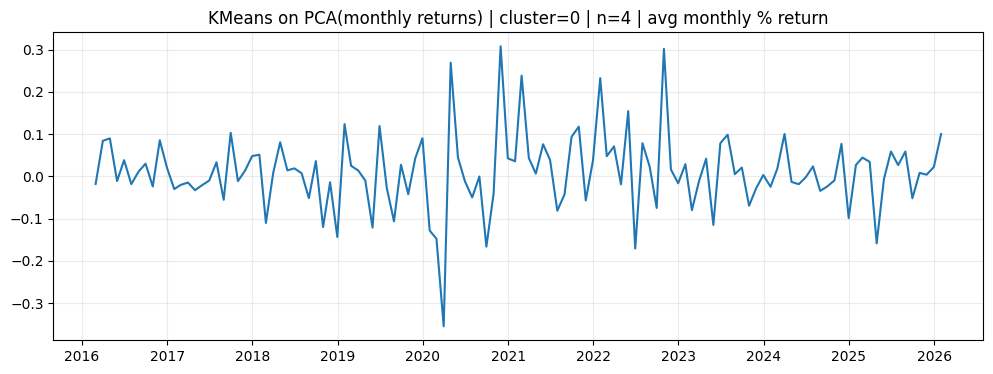

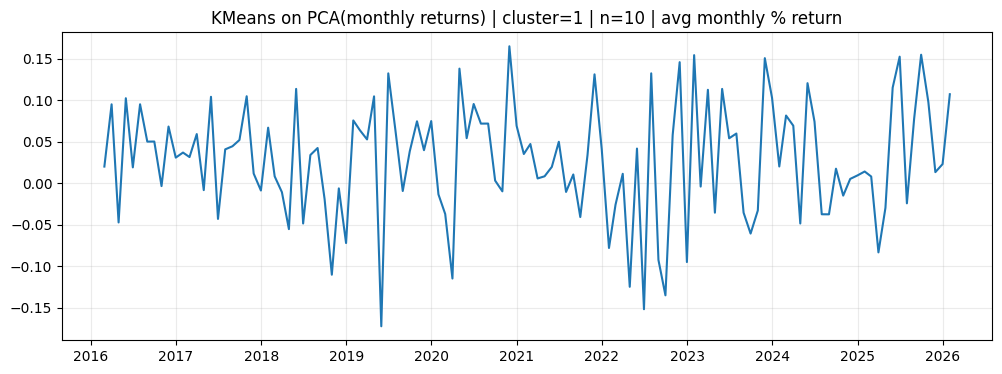

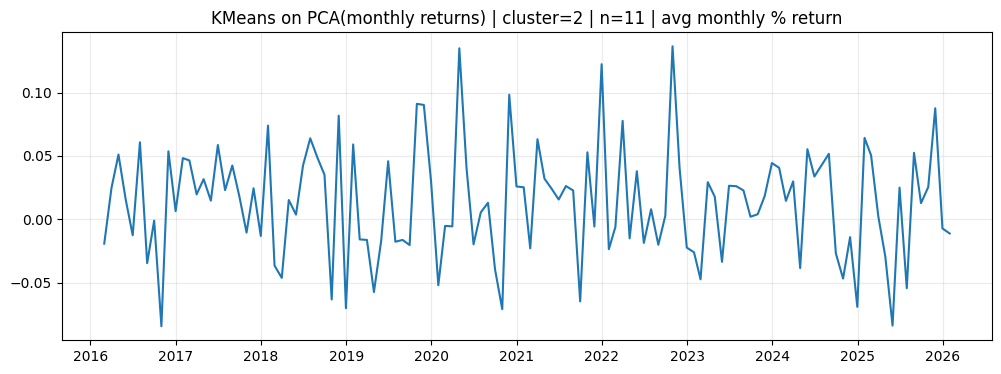

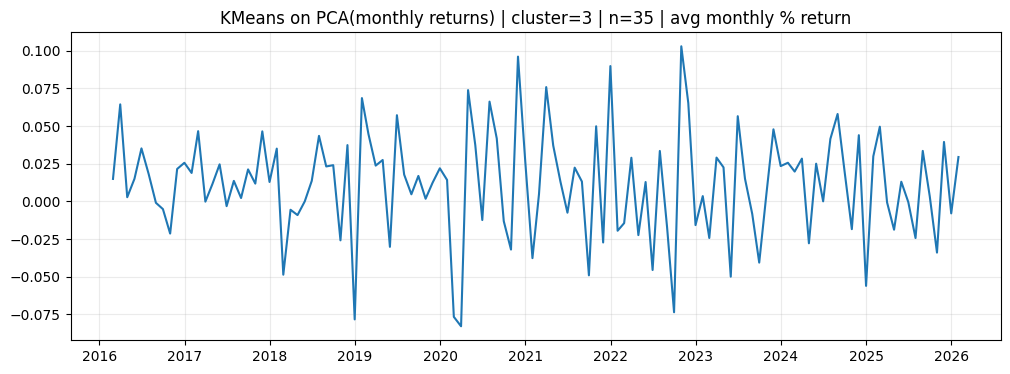

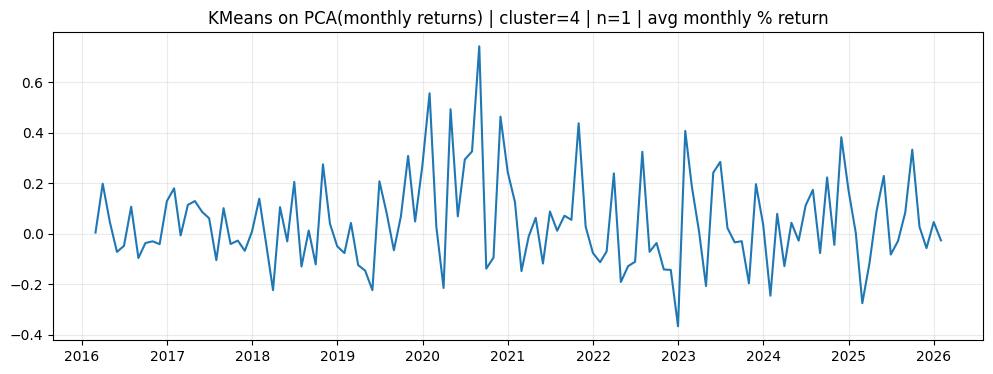

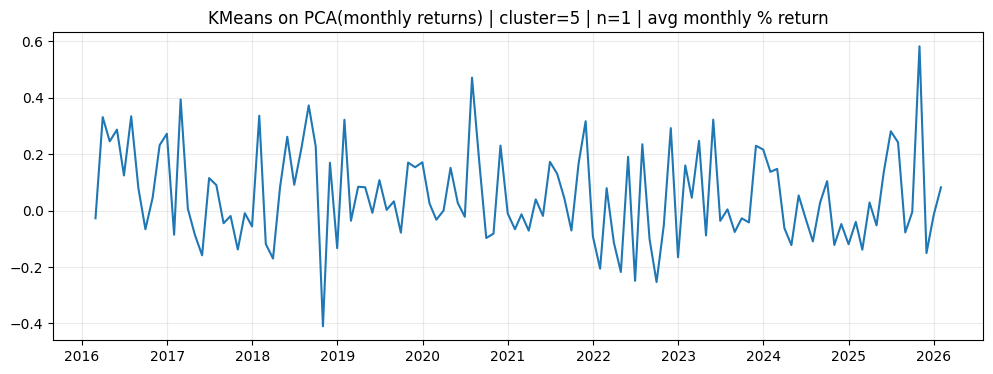

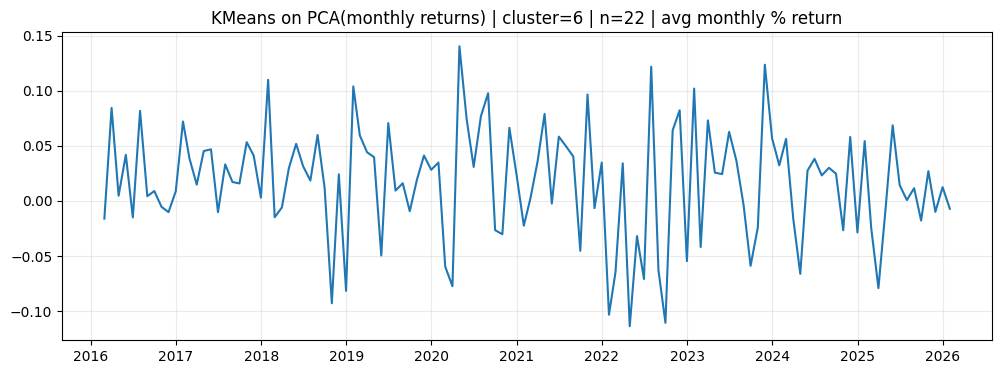

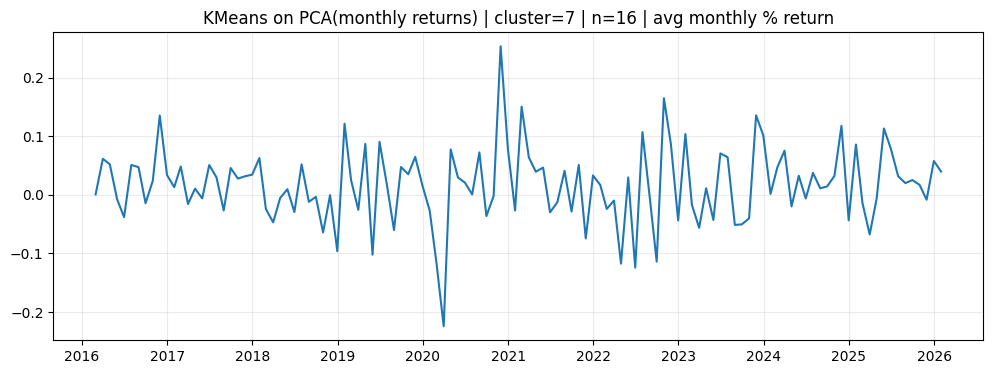

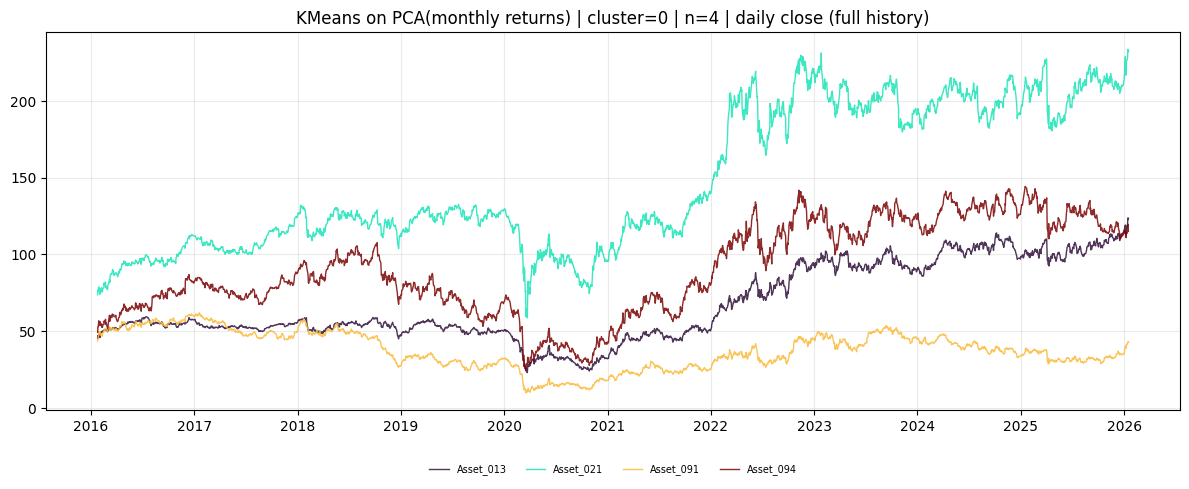

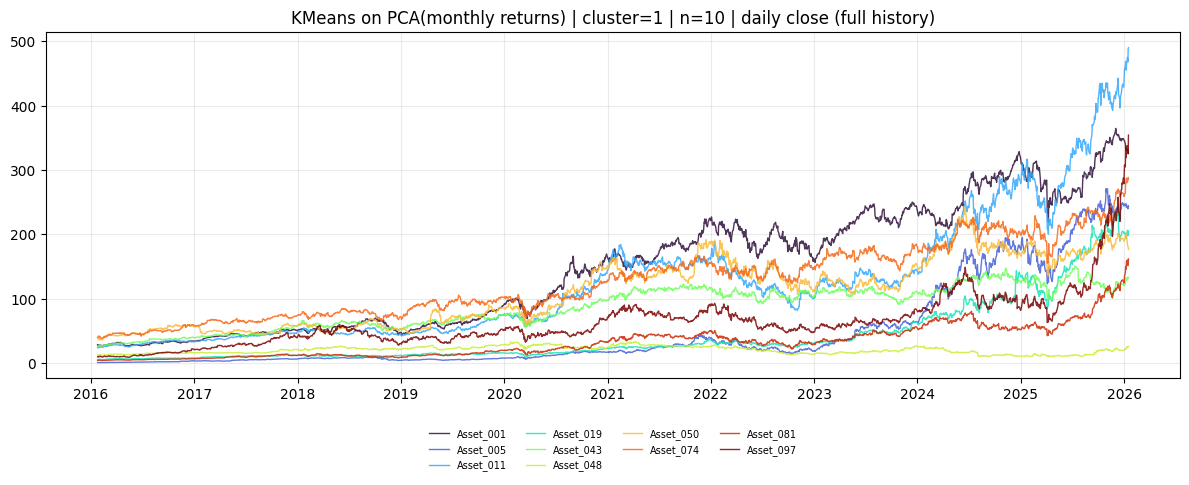

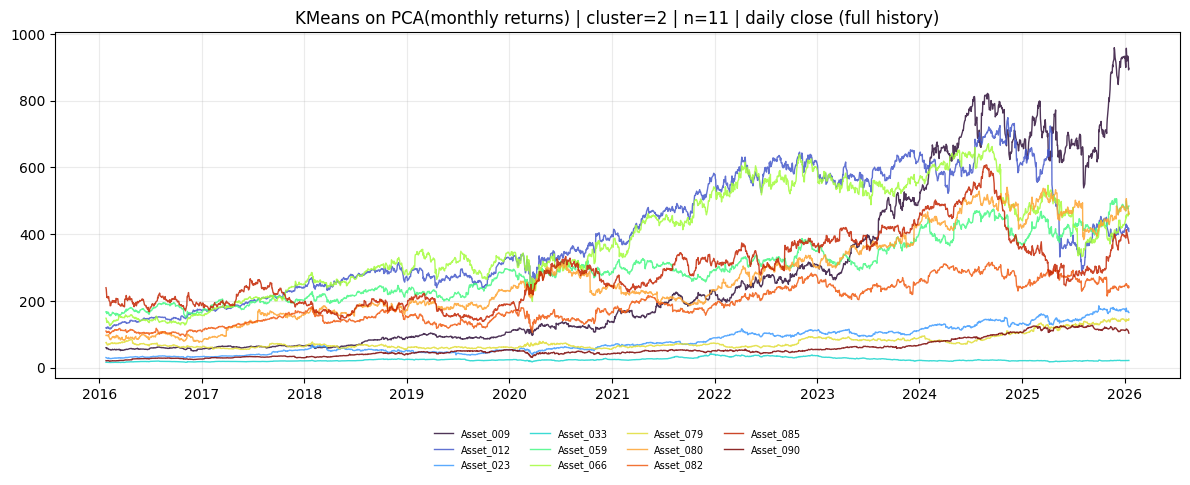

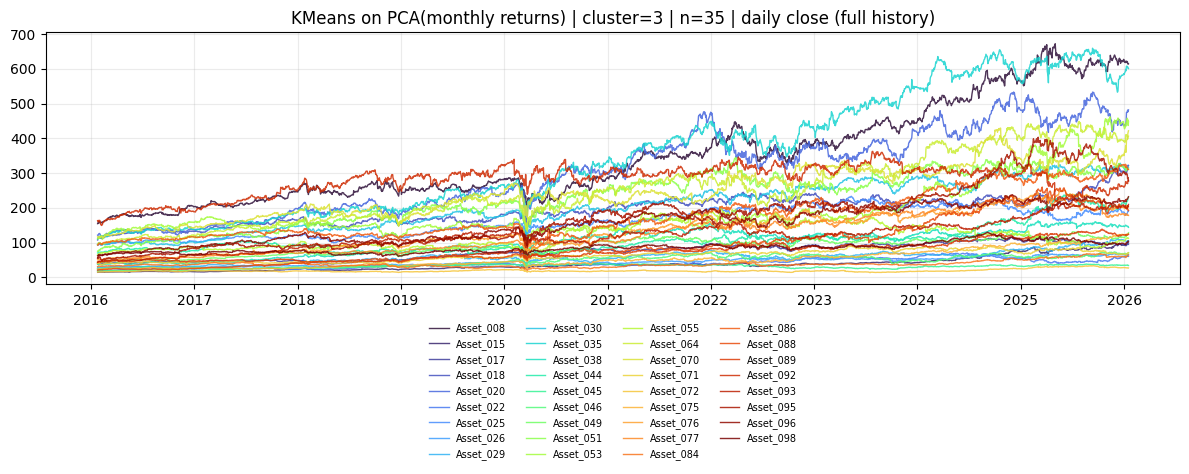

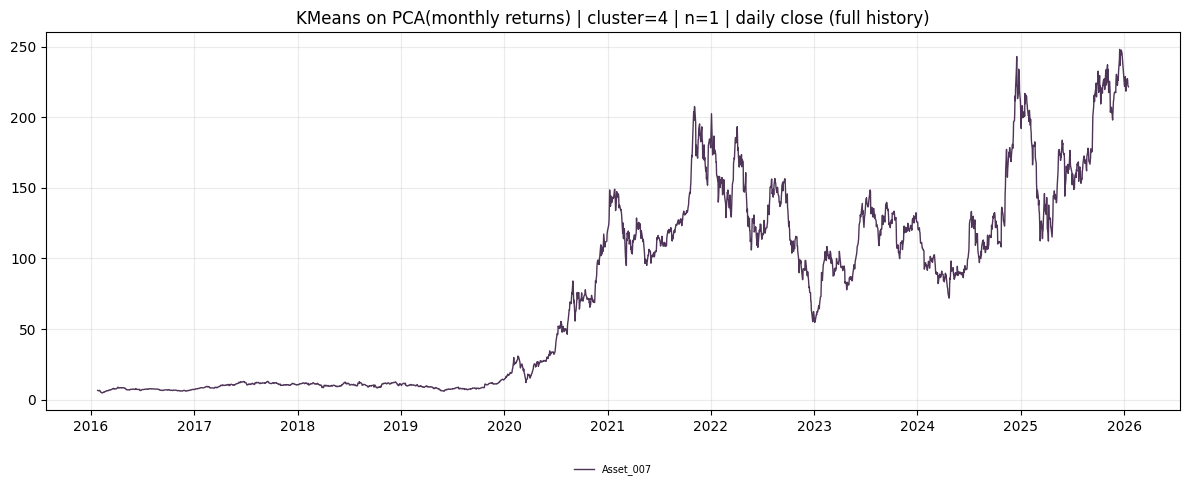

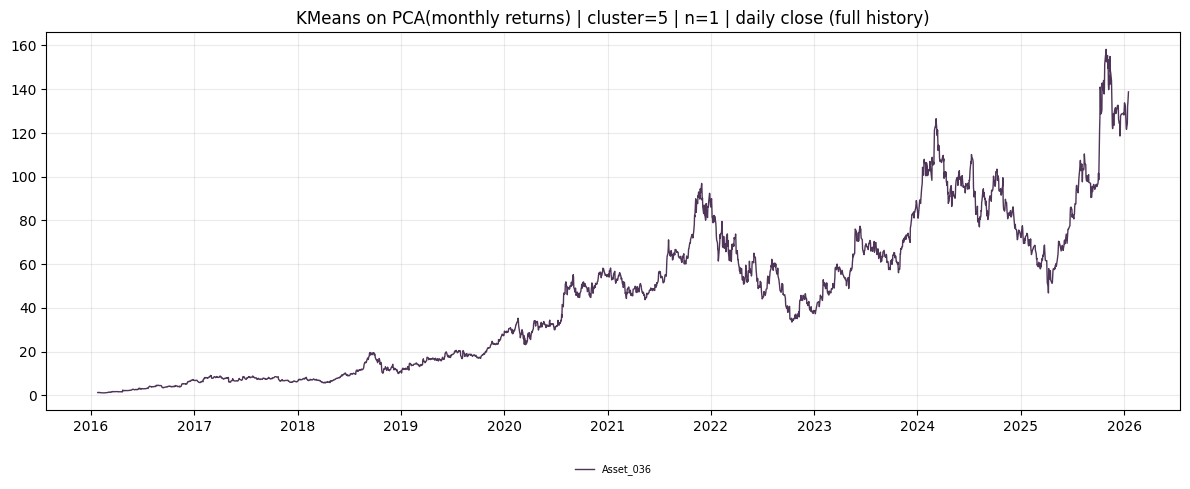

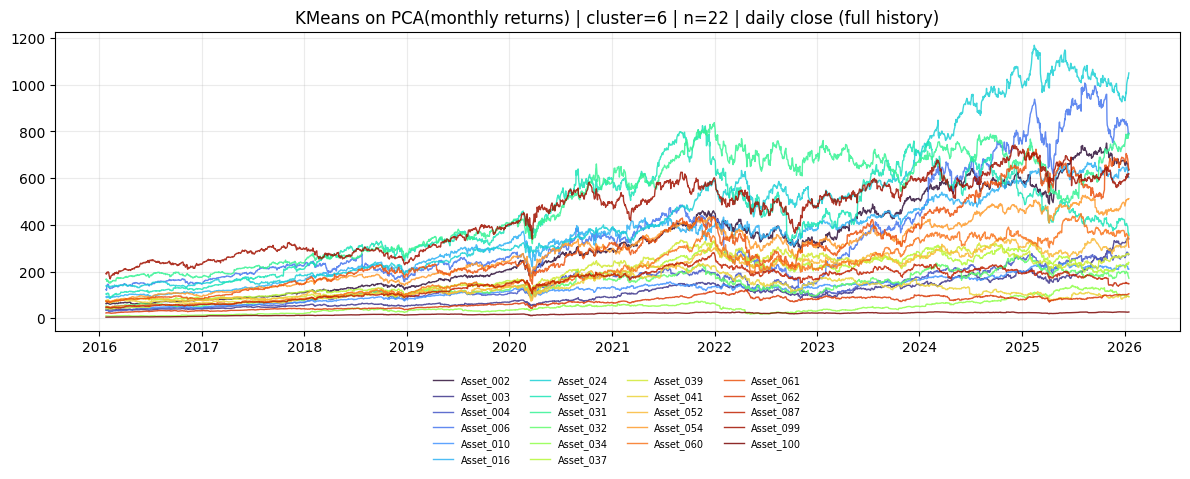

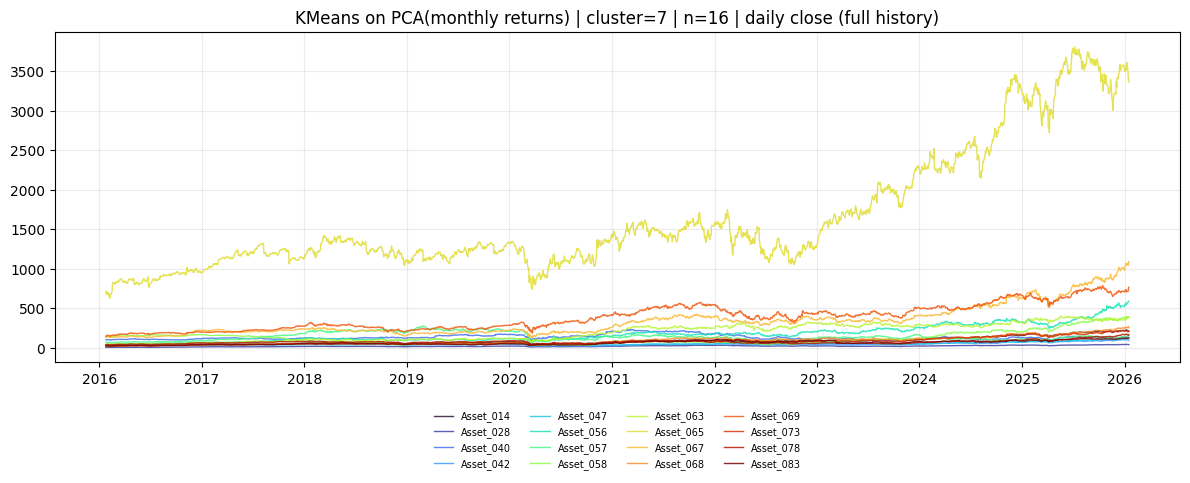

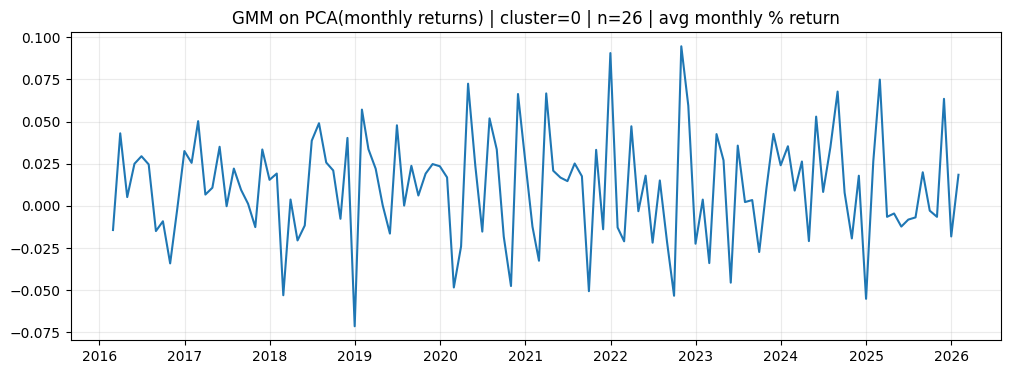

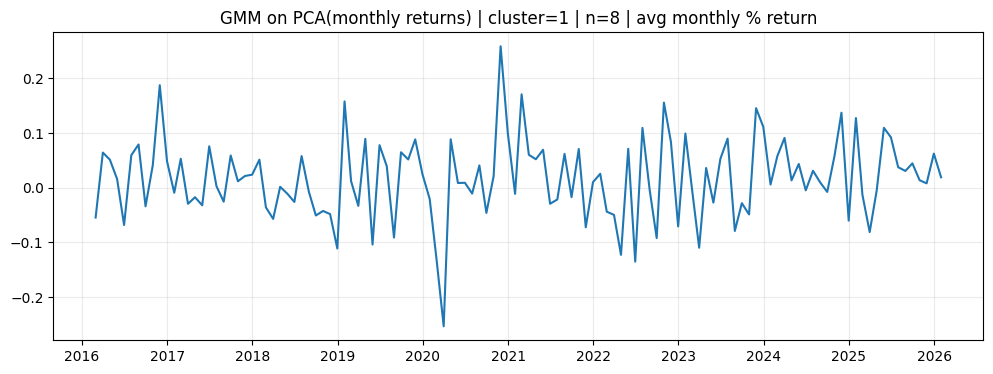

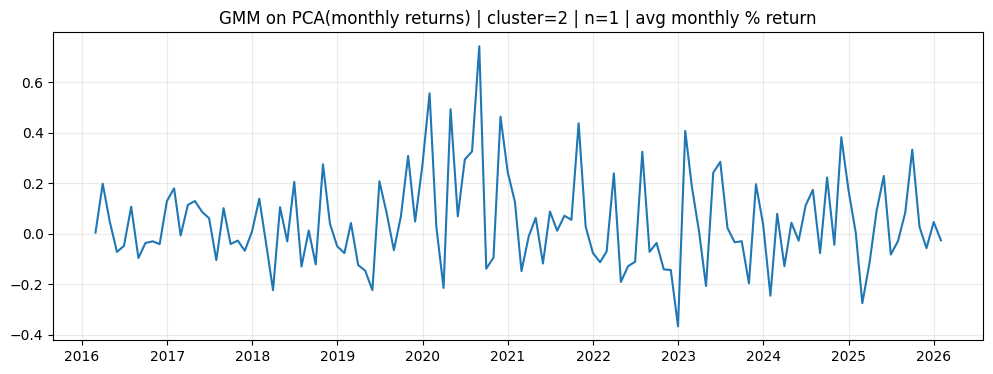

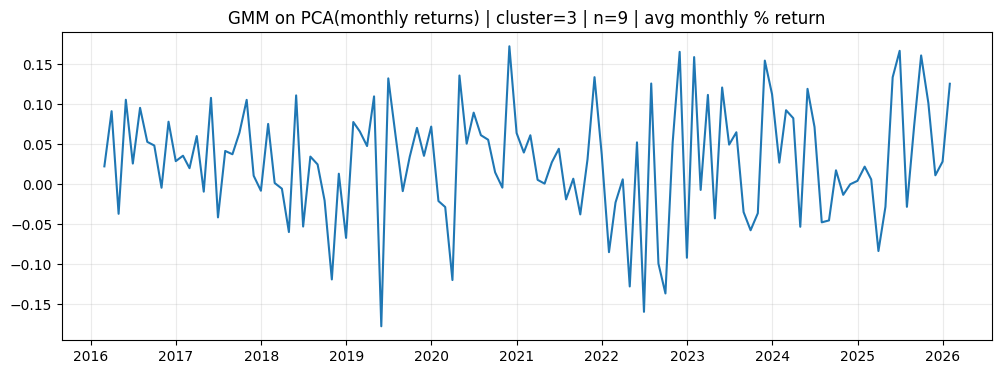

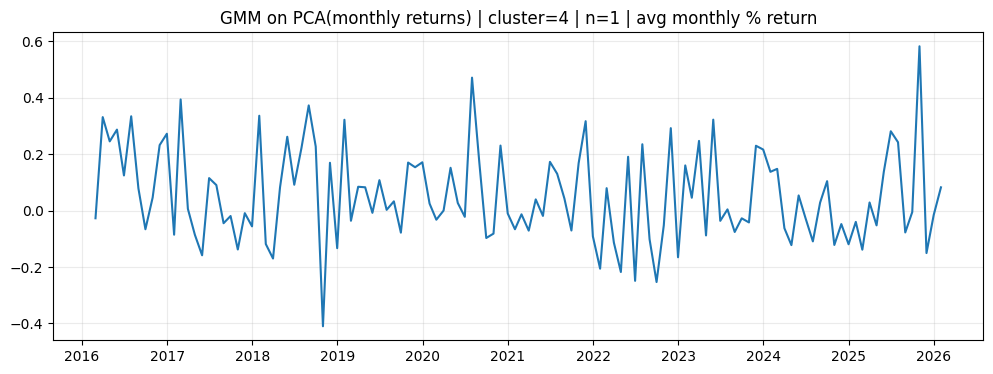

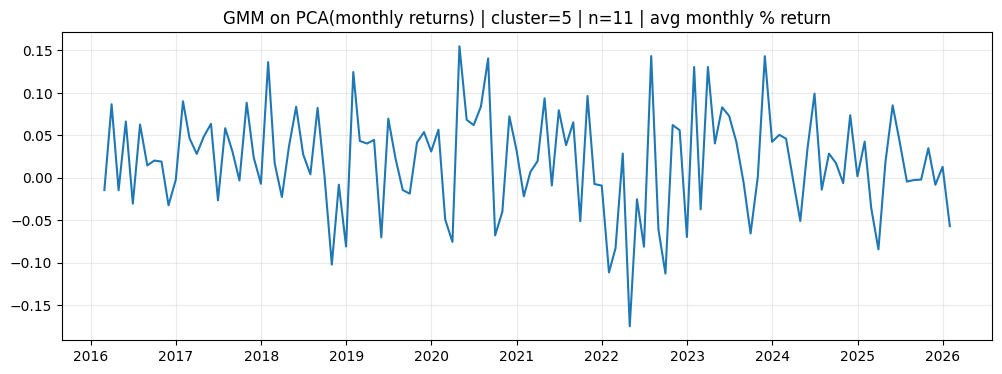

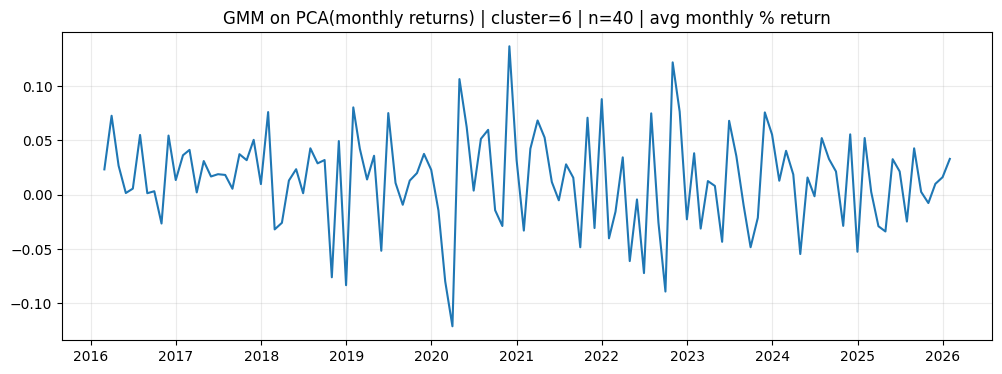

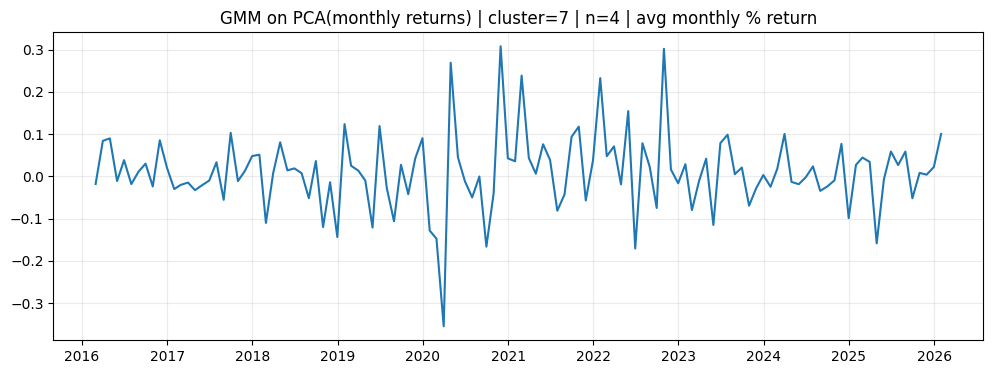

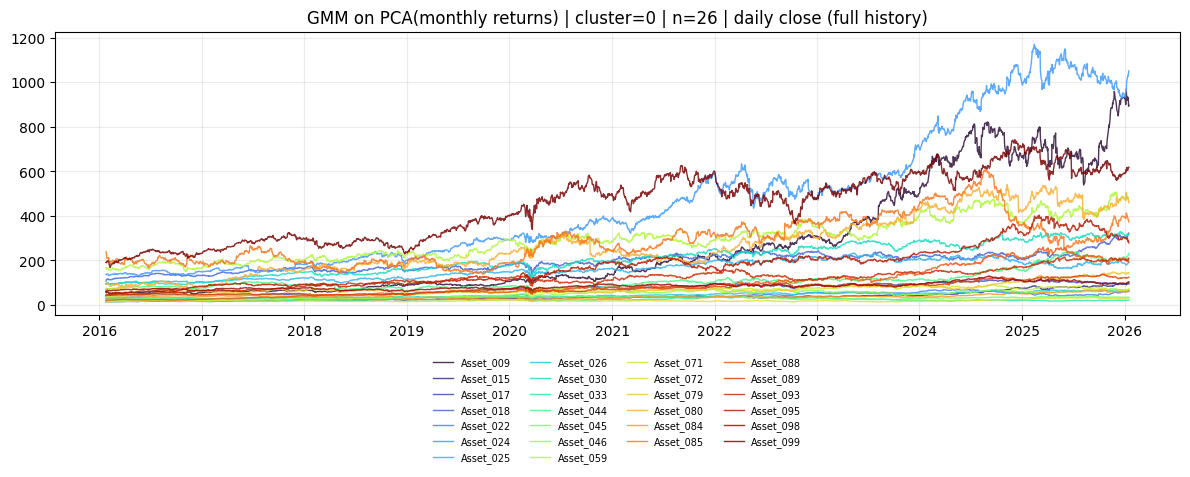

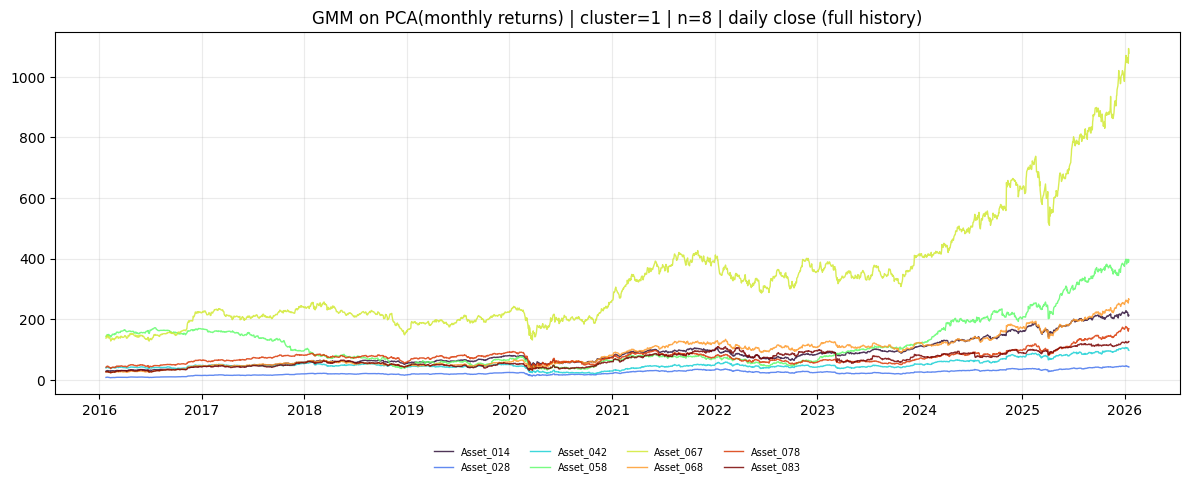

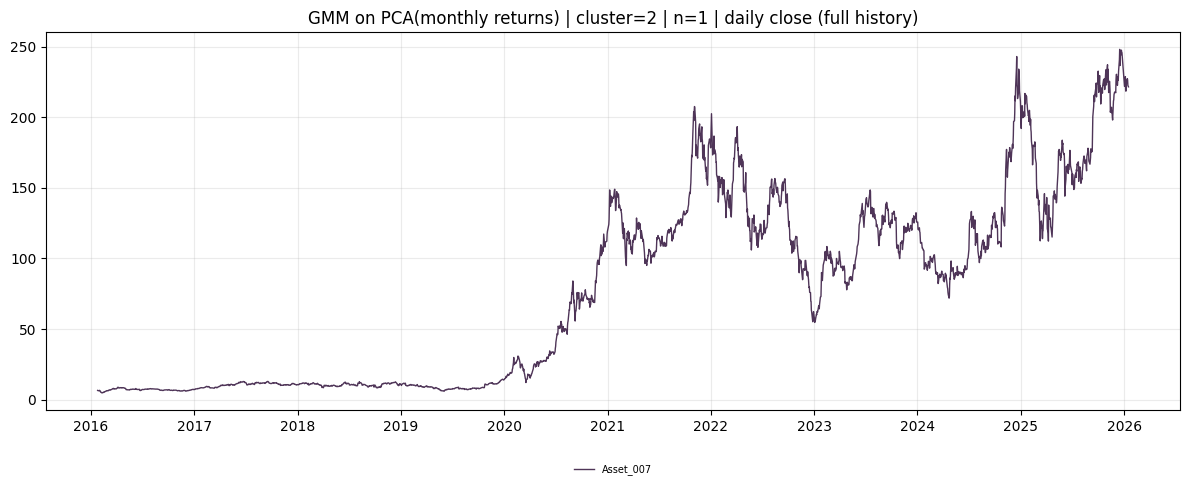

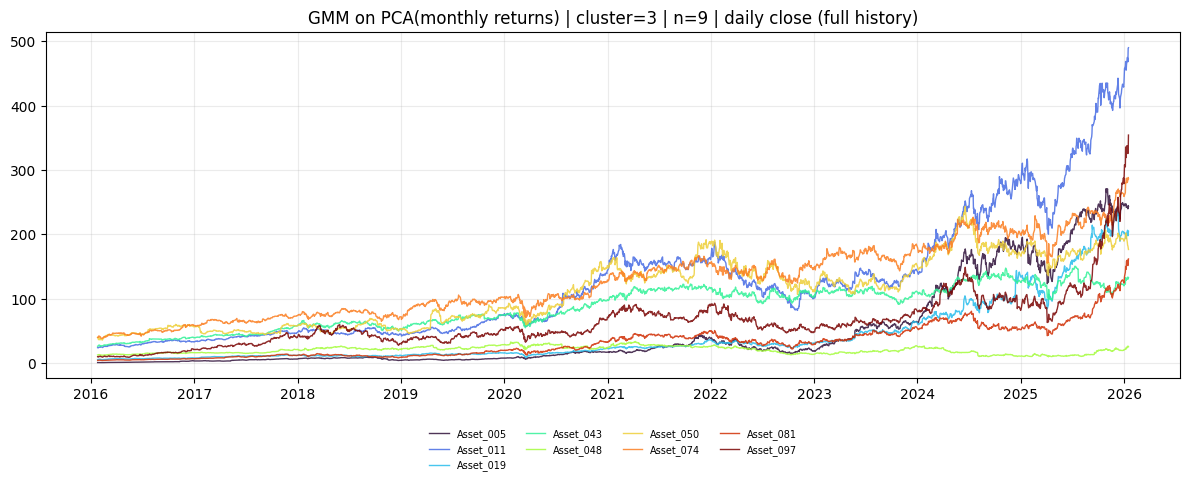

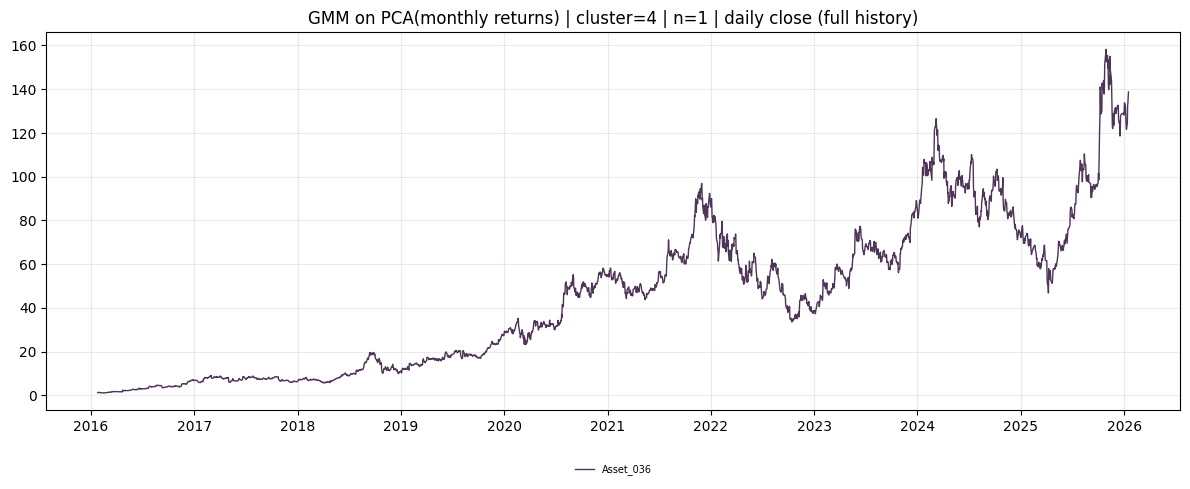

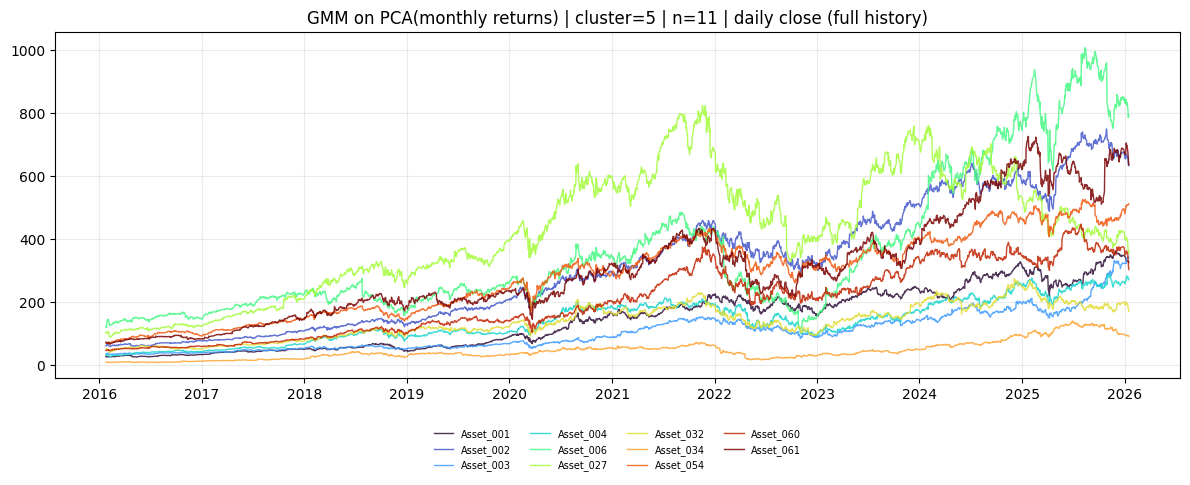

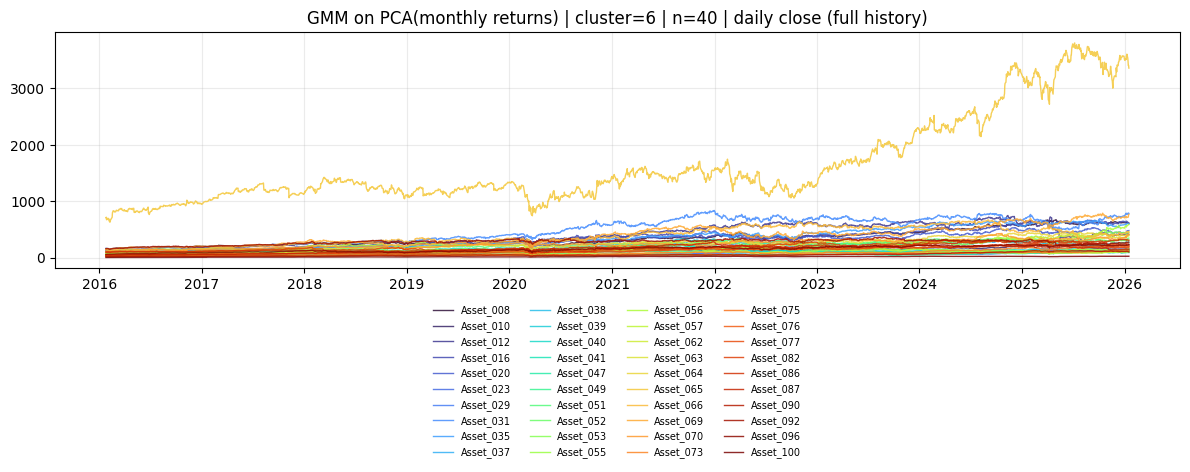

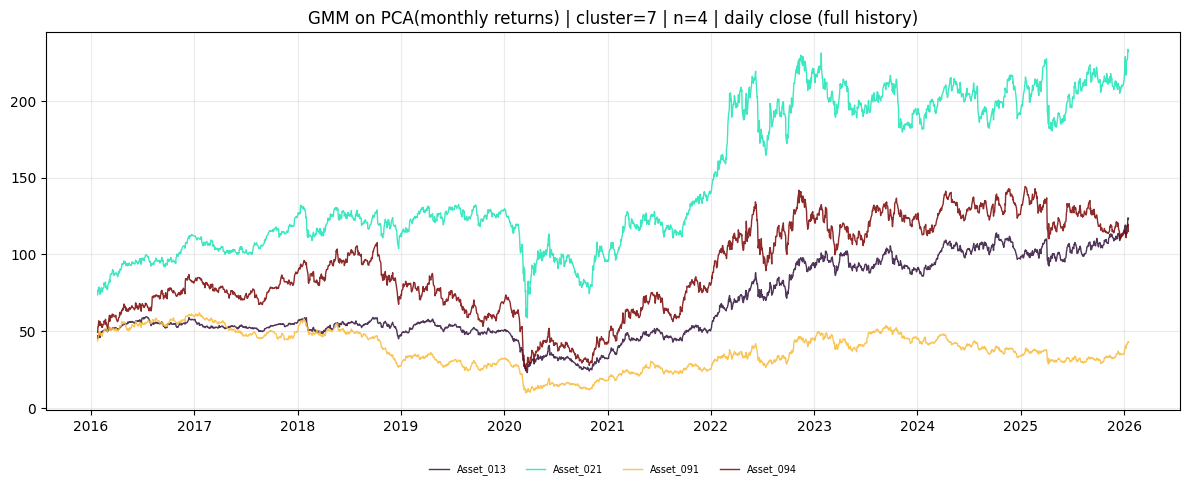

In [7]:
# Plot cluster-average monthly returns (train window) and daily prices (full history)

def plot_cluster_avg_monthly(groups: dict[int, list[str]], monthly_ret: pd.DataFrame, *, title: str) -> None:
    for cid in sorted(groups.keys()):
        if cid == -1:
            continue
        syms = [s for s in groups[cid] if s in monthly_ret.columns]
        if len(syms) == 0:
            continue
        s = monthly_ret.loc[:, syms].mean(axis=1)
        plt.figure(figsize=(12,4))
        plt.plot(s.index, s.values)
        plt.title(f'{title} | cluster={cid} | n={len(syms)} | avg monthly % return')
        plt.grid(True, alpha=0.25)
        plt.show()


def plot_cluster_prices(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, title: str) -> None:
    for cid in sorted(groups.keys()):
        if cid == -1:
            continue
        syms = [s for s in groups[cid] if s in close_daily.columns]
        if len(syms) == 0:
            continue

        # Deterministic unique-ish colors per asset within cluster
        colors = plt.cm.turbo(np.linspace(0.0, 1.0, len(syms)))
        plt.figure(figsize=(12, 5))
        for i, s in enumerate(syms):
            plt.plot(close_daily.index, close_daily[s].astype(float), linewidth=1.0, alpha=0.85, color=colors[i], label=str(s))
        plt.title(f'{title} | cluster={cid} | n={len(syms)} | daily close (full history)')
        plt.grid(True, alpha=0.25)
        # Legend lists each asset name with its line color
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=7, frameon=False)
        plt.tight_layout()
        plt.show()
plot_cluster_avg_monthly(km_groups, monthly_ret, title='KMeans on PCA(monthly returns)')
plot_cluster_prices(km_groups, close_daily, title='KMeans on PCA(monthly returns)')

plot_cluster_avg_monthly({k:v for k,v in db_groups.items() if k != -1}, monthly_ret, title='DBSCAN on PCA(monthly returns)')
plot_cluster_prices({k:v for k,v in db_groups.items() if k != -1}, close_daily, title='DBSCAN on PCA(monthly returns)')

plot_cluster_avg_monthly(gmm_groups, monthly_ret, title='GMM on PCA(monthly returns)')
plot_cluster_prices(gmm_groups, close_daily, title='GMM on PCA(monthly returns)')
